* 일단 코드 무작정 따라가기
  
        single_digits_addition.ipynb

In [3]:
import tensorflow as tf
import ltn
import baselines, data, commons
import matplotlib.pyplot as plt

Result label is 16


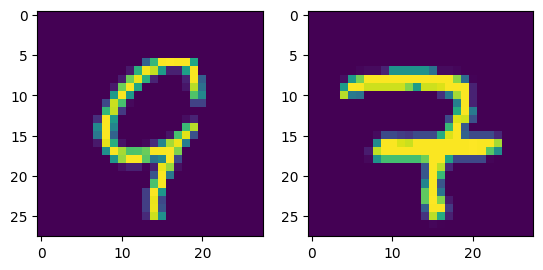

In [7]:
ds_train, ds_test = data.get_mnist_op_dataset(
    count_train=3000,
    count_test=1000,
    buffer_size=3000,
    batch_size=16,
    n_operands=2,
    op=lambda args: args[0]+args[1]
)

x, y, z = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0])

In [12]:
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
Digit = ltn.Predicate.FromLogits(logits_model, activation_function="softmax")

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(), semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(), semantics="exists")

In [13]:
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])

@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.Variable("x", images_x)
    images_y = ltn.Variable("y", images_y)
    labels_z = ltn.Variable("z", labels_z)
    axiom = Forall(
            ltn.diag(images_x, images_y, labels_z),
            Exists(
                (d1, d2),
                And(Digit([images_x, d1]), Digit([images_y, d2])),
                mask=equals([add([d1, d2]), labels_z]),
                p=p_schedule
            ),
            p=2
    )
    sat = axiom.tensor
    return sat

images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
axioms(images_x, images_y, labels_z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010598183>

In [18]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")
}

@tf.function
def train_step(images_x, images_y, labels_z, **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1. - axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)

    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]), axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]), axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))

@tf.function
def test_step(images_x, images_y, labels_z, **parameters):
    # loss
    loss = 1.-axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)

    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]), axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]), axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z, tf.cast(labels_z, predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match, tf.float32)))

In [15]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0, 4):
    scheduled_parameters[epoch] = {"p_schedule": tf.constant(1.)}
for epoch in range(4, 8):
    scheduled_parameters[epoch] = {"p_schedule": tf.constant(2.)}
for epoch in range(8, 12):
    scheduled_parameters[epoch] = {"p_schedule": tf.constant(4.)}
for epoch in range(12, 20):
    scheduled_parameters[epoch] = {"p_schedule": tf.constant(6.)}

In [19]:
commons.train(
    20,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    scheduled_parameters=scheduled_parameters
)

Epoch 0, train_loss: 0.9460, train_accuracy: 0.3025, test_loss: 0.9173, test_accuracy: 0.4306
Epoch 1, train_loss: 0.8928, train_accuracy: 0.6094, test_loss: 0.8738, test_accuracy: 0.6776
Epoch 2, train_loss: 0.8732, train_accuracy: 0.7204, test_loss: 0.8688, test_accuracy: 0.7044
Epoch 3, train_loss: 0.8670, train_accuracy: 0.7447, test_loss: 0.8643, test_accuracy: 0.7272
Epoch 4, train_loss: 0.7240, train_accuracy: 0.7387, test_loss: 0.7287, test_accuracy: 0.6984
Epoch 5, train_loss: 0.6620, train_accuracy: 0.8787, test_loss: 0.6563, test_accuracy: 0.8700
Epoch 6, train_loss: 0.6320, train_accuracy: 0.9392, test_loss: 0.6473, test_accuracy: 0.8819
Epoch 7, train_loss: 0.6233, train_accuracy: 0.9515, test_loss: 0.6428, test_accuracy: 0.8938
Epoch 8, train_loss: 0.4454, train_accuracy: 0.9375, test_loss: 0.4796, test_accuracy: 0.8750
Epoch 9, train_loss: 0.4272, train_accuracy: 0.9508, test_loss: 0.4593, test_accuracy: 0.9028
Epoch 10, train_loss: 0.4191, train_accuracy: 0.9581, test_l

그래... 훈련은 됐는데 그래서 이게 어떻게 돌아가는 거지?

개별 케이스로 통과시켜보자

Result label is 9


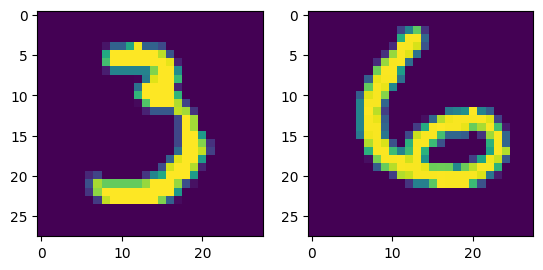

In [21]:
plt.subplot(121)
plt.imshow(images_x[0][:,:,0])
plt.subplot(122)
plt.imshow(images_y[0][:,:,0])
print("Result label is %i" % labels_z[0])

In [39]:
x_hat = tf.argmax(logits_model([images_x[0].reshape(1, 28, 28, 1)]), axis=-1)
y_hat = tf.argmax(logits_model([images_y[0].reshape(1, 28, 28, 1)]), axis=-1)
z_hat = x_hat + y_hat
z_hat

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([9], dtype=int64)>

In [41]:
match = tf.equal(z_hat, tf.cast(labels_z[0], z_hat.dtype))
match

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

In [42]:
tf.reduce_mean(tf.cast(match, tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

* logits_model이라는 클래스가 어떻게 굴러가는지 살펴보자

        baselines.py

In [43]:
# baselines.py

from tensorflow.keras import layers

class MNISTConv(tf.keras.Model):
    # CNN that returns linear embeddings for MNIST images
    
    def __init__(self, hidden_conv_filters=(6, 16), kernel_size=(5, 5), hidden_dense_sizes=(100, )):
        super(MNISTConv, self).__init__()
        self.convs = [layers.Conv2D(f, k, activation="elu") for f, k in zip(hidden_conv_filters, kernel_size)] # (6, 5) (16, 5)?
        self.maxpool = layers.MaxPool2D((2, 2))
        self.flatten = layers.Flatten()
        self.denses = [layers.Dense(s, activation="elu") for s in hidden_dense_sizes]
    
    def call(self, x):
        for conv in self.convs:
            x = conv(x)
            x = self.maxpool(x)
        x = self.flatten(x)
        for dense in self.denses:
            x = dense(x)
        return x

In [49]:
x = images_x[0].reshape(1, 28, 28, 1)
y = images_y[0].reshape(1, 28, 28, 1)
layer_Conv = MNISTConv()

In [50]:
for i, conv in enumerate(layer_Conv.convs):
    x = conv(x)
    print(f"Shape after {i}th Conv layer: {x.shape}")
    x = layer_Conv.maxpool(x)
    print(f"Shape after {i}th Maxpooling: {x.shape}")
print("")

x = layer_Conv.flatten(x)
print(f"Shape after flatten: {x.shape}")
print("")

for i, dense in enumerate(layer_Conv.denses):
    x = dense(x)
    print(f"Shape after {i}th Dense layer: {x.shape}")
print("")

print(f"Final Shape: {x.shape}")

Shape after 0th Conv layer: (1, 24, 24, 6)
Shape after 0th Maxpooling: (1, 12, 12, 6)
Shape after 1th Conv layer: (1, 8, 8, 16)
Shape after 1th Maxpooling: (1, 4, 4, 16)

Shape after flatten: (1, 256)

Shape after 0th Dense layer: (1, 100)

Final Shape: (1, 100)


In [ ]:
class SingleDigit(tf.keras.Model):
    # Model classifying one digit image into 10 possible classes.

    def __init__(self, hidden_dense_sizes=(84,), inputs_as_a_list=False):
        super(SingleDigit, self).__init__()
        self.mnistconv = MNISTConv()
        self.denses = [layers.Dense(s, activation="elu") for s in hidden_dense_sizes]
        self.dense_class = layers.Dense(10)
        self.inputs_as_list = inputs_as_a_list
    
    def call(self, inputs):
        x = inputs if not self.inputs_as_list else inputs[0]
        x = self.mnistconv(x) # (#, 28, 28, 1) -> (#, 100)
        for dense in self.denses:
            x = dense(x) # (#, 100) -> (#, 84)
        x = self.dense_class(x) # (#, 84) -> (#, 10)
        return x

그냥 CNN의 Convolutional Layer 뒤에 Dense 두 개 붙인, 조금 깊은 CNN?

아무래도 logits_model은 그냥 숫자를 인식해서 ltn으로 던져주는 역할만 하는 듯

그럼 logical하게 "아 얘가 이 두 숫자를 더한 걸 return해주길 원하는구나!를 인식하는 부분이 어디인거지

        single_digits_addition.ipynb

In [53]:
Digit = ltn.Predicate.FromLogits(logits_model, activation_function="softmax")

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(), semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(), semantics="exists")

add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])

In [ ]:
@tf.function
def axioms(images_x, images_y, lab)